## Experiment 1

In the first experiment, the Oxford dataset is used.
Time series data from the behavior of the 8 cells
are extracted, and the dataset is randomly split into
85% for the training set and 15% for the test set.

In [2]:
# importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import math
import numpy as np
from scipy.ndimage import gaussian_filter1d , gaussian_filter

from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.performance_metrics.forecasting import mean_absolute_error,mean_absolute_percentage_error
from sktime.transformations.panel.padder import PaddingTransformer

/home/apetrella/miniconda3/envs/battery_tsc/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Time series Extraction with label(SoH), from Oxford dataset


#import Oxford Dataset nad remove metadata
oxford_dataset = scipy.io.loadmat('dataset/Oxford/Oxford_Battery_Degradation_Dataset_1.mat', simplify_cells=True)
del oxford_dataset["__header__"]
del oxford_dataset["__version__"]
del oxford_dataset["__globals__"]


# extraction of capacity q for every battery
capacity={}          
for ox_key, ox_value in oxford_dataset.items():
    capacity[ox_key] = []
    for value in ox_value:
        last = ox_value[value]['C1ch']['q'].shape[0] - 1
        capacity[ox_key].append(ox_value[value]['C1ch']['q'][last])


# From capacity to SoH 
# SoH = q_k / q_0
y={}
for id_battery, values_battery in capacity.items():
    y[id_battery]=[]
    for key, value in enumerate(values_battery):
        y[id_battery].append(  capacity[id_battery][key] / capacity[id_battery][0] ) 


# CREO IL PANDA DATAFRAME

#Crete a dictionary with this structure: {"num ciclo _ num batteria (id)": , "voltage (v)": , "temperature (T)": }
# For every multivariate time series, there is a label (the SoH)

dict_oxford={}
for i, cell in enumerate(['Cell1','Cell2','Cell3','Cell4','Cell5','Cell6','Cell7','Cell8']):

    int_idch = 0
    for idch_key, idch_value in oxford_dataset[cell].items():
        
        
        dict_oxford[str(idch_key) + '_'+cell] = {
            'v' : pd.Series(idch_value['C1ch']['v']),
            'T' : pd.Series(idch_value['C1ch']['T']),
            'SoH' : round(y[cell][int_idch]*100)
        }
        int_idch += 1

#from dict to dataframe 
df= pd.DataFrame.from_dict(dict_oxford).transpose()
df.head()


,v,T,SoH
cyc0000_Cell1,0 2.719213 1 2.856135 2 2.87...,0 41.295536 1 41.000046 2 40...,100
cyc0100_Cell1,0 2.719614 1 2.852486 2 2.87...,0 40.980995 1 40.862762 2 40...,99
cyc0200_Cell1,0 2.719775 1 2.848395 2 2.87...,0 41.243099 1 40.850254 2 40...,98
cyc0300_Cell1,0 2.720641 1 2.844529 2 2.86...,0 40.928558 1 40.887695 2 40...,98
cyc0400_Cell1,0 2.720881 1 2.843206 2 2.86...,0 40.823727 1 40.812817 2 40...,97


In [4]:
# divide dataframe into train set e validation set

np.random.seed(2)
msk = np.random.rand(len(df)) < 0.85

x_train = df[msk]
y_train = x_train['SoH'].copy().astype('int')
x_train = x_train.drop(columns=['SoH'])

x_test = df[~msk]
y_test = x_test['SoH'].copy().astype('int') 
x_test = x_test.drop(columns=['SoH'])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(446, 2) (446,)
(73, 2) (73,)


In [5]:

padded_clf = PaddingTransformer() * RandomIntervalClassifier(n_intervals=5, random_state=1)
padded_clf.fit(x_train, y_train)

y_pred = padded_clf.predict(x_test)




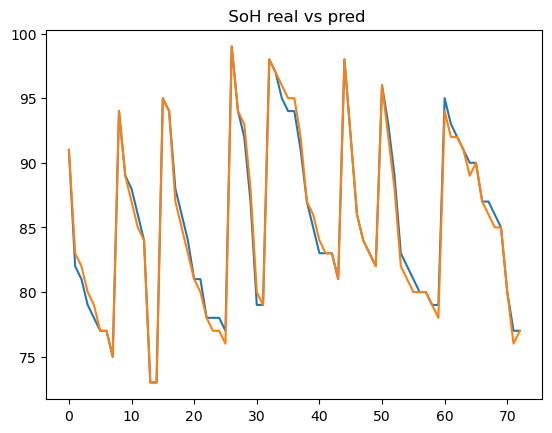

MAEP = 0.005482782571159821
MAE = 0.4657534246575342
RMSE = 0.6824612990181452


In [6]:
# plot "real vs pred" and metrics result 

MAEP = mean_absolute_percentage_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(np.square(np.subtract(y_test,y_pred)).mean())

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

print("MAEP = " + str(MAEP))
print("MAE = " + str(MAE))
print("RMSE = " + str(RMSE))

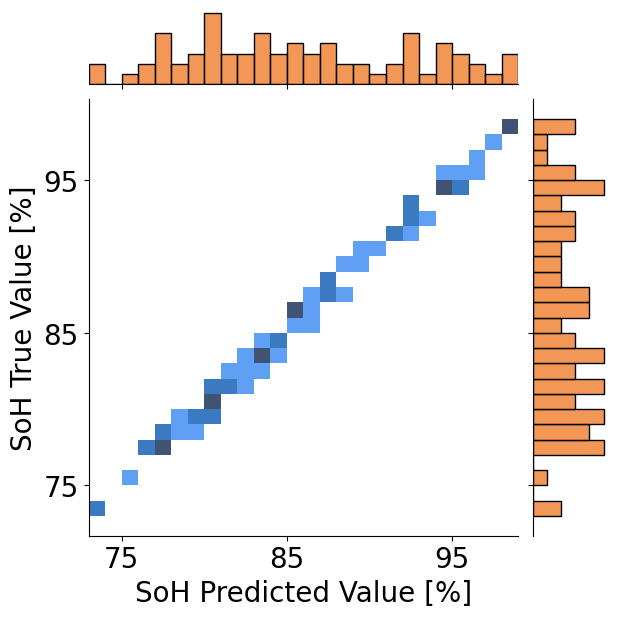

In [7]:
#PLOTTING


import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


real_pred = {
    'real':y_test.values,
    'pred':y_pred
}
df_plot = pd.DataFrame(real_pred)

colors = ["#F0741E", "#276CB3"]

class_names = np.union1d(np.unique(df_plot['real']), (np.unique(df_plot['pred'])))


g = sns.jointplot(x="pred", 
                  y="real", 
                  data=df_plot, 
                  kind="hist", 
                  marginal_kws={"color": colors[0], "bins":len(class_names)},
                  joint_kws={"color": colors[1], "bins": len(class_names)} 
                  )


g.ax_joint.tick_params(axis="both", which="major", labelsize=20)
ticks = np.arange(75, 100, 10)
labels = [f'{x}' for x in ticks]
g.ax_joint.set_xlim([min(class_names),max(class_names)])
#g.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=3))  # Auto tick locator
#g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=3))  #
g.ax_joint.set_yticks(ticks,labels=labels)
g.ax_joint.set_xticks(ticks,labels=labels)

g.set_axis_labels(
    'SoH Predicted Value [%]', 'SoH True Value [%]' ,fontsize=20
)

plt.savefig('plot/cell1_100_oxford_8515.png', dpi=300, bbox_inches="tight")

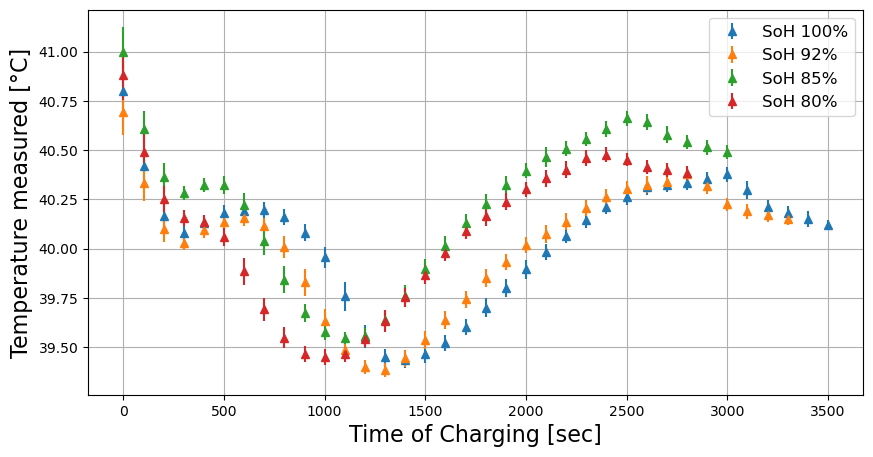

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Genera un array di esempio di lunghezza 1000
data0000 = dict_oxford['cyc0000_Cell1']['T']

# Calcola la media e la deviazione standard ogni 50 punti
window_size = 100
means0000 = []
std_devs0000 = []
for i in range(0, len(data0000), window_size):
    window = data0000[i:i + window_size]
    means0000.append(np.mean(window))
    std_devs0000.append(np.std(window))

data1000 = dict_oxford['cyc1000_Cell1']['T']
# Calcola la media e la deviazione standard ogni 50 punti
window_size = 100
means1000 = []
std_devs1000 = []
for i in range(0, len(data1000), window_size):
    window = data1000[i:i + window_size]
    means1000.append(np.mean(window))
    std_devs1000.append(np.std(window))

data3000 = dict_oxford['cyc3000_Cell1']['T']
# Calcola la media e la deviazione standard ogni 50 punti
window_size = 100
means3000 = []
std_devs3000 = []
for i in range(0, len(data3000), window_size):
    window = data3000[i:i + window_size]
    means3000.append(np.mean(window))
    std_devs3000.append(np.std(window))

data5000 = dict_oxford['cyc5000_Cell1']['T']
# Calcola la media e la deviazione standard ogni 50 punti
window_size = 100
means5000 = []
std_devs5000 = []
for i in range(0, len(data5000), window_size):
    window = data5000[i:i + window_size]
    means5000.append(np.mean(window))
    std_devs5000.append(np.std(window))

# Crea gli intervalli per l'asse x
x0000 = np.arange(0, len(data0000), window_size)
x1000 = np.arange(0, len(data1000), window_size)
x3000 = np.arange(0, len(data3000), window_size)
x5000 = np.arange(0, len(data5000), window_size)


# Plot della media e della deviazione standard
plt.figure(figsize=(10, 5))
plt.errorbar(x0000, means0000, std_devs0000, linestyle='None', marker='^', label='SoH 100%' )
plt.errorbar(x1000, means1000, std_devs1000, linestyle='None', marker='^', label='SoH 92% ')
plt.errorbar(x3000, means3000, std_devs3000, linestyle='None', marker='^', label='SoH 85%' )
plt.errorbar(x5000, means5000, std_devs5000, linestyle='None', marker='^', label='SoH 80%')

#plt.title('Media e Deviazione Standard Temperatura ogni 100 punti - Oxford Dataset')
plt.xlabel('Time of Charging [sec]',fontsize=16)
plt.ylabel('Temperature measured [°C]',fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
#plt.show()
plt.savefig('plot/Temperature_Measured_oxford.png', dpi=300, bbox_inches="tight")

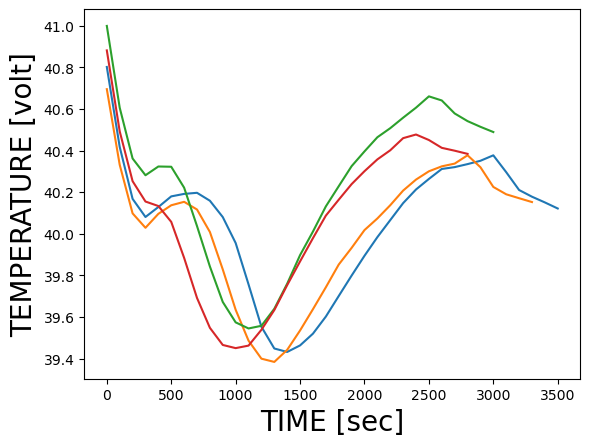

In [27]:
#plot per l'immaginedel workflow

plt.plot(x0000,means0000)
plt.plot(x1000,means1000)
plt.plot(x3000,means3000)
plt.plot(x5000,means5000)
plt.xlabel('TIME [sec]',fontsize=20)
plt.ylabel('TEMPERATURE [volt]',fontsize=20)
#plt.grid(True)
plt.savefig('plot/Temperature_WORKFLOW.png', dpi=300, bbox_inches="tight")
plt.show()

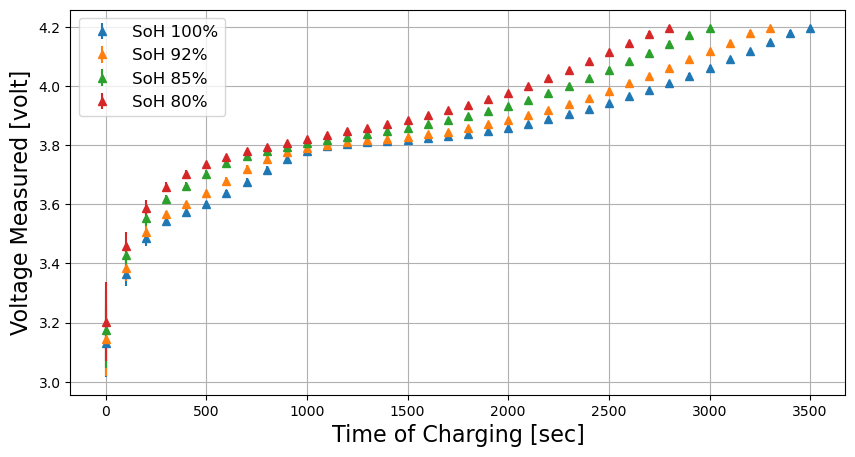

In [23]:

# Genera un array di esempio di lunghezza 1000
data0000 = dict_oxford['cyc0000_Cell1']['v']
# Calcola la media e la deviazione standard ogni 50 punti
window_size = 100
means0000 = []
std_devs0000 = []
for i in range(0, len(data0000), window_size):
    window = data0000[i:i + window_size]
    means0000.append(np.mean(window))
    std_devs0000.append(np.std(window))

data1000 = dict_oxford['cyc1000_Cell1']['v']
# Calcola la media e la deviazione standard ogni 50 punti
means1000 = []
std_devs1000 = []
for i in range(0, len(data1000), window_size):
    window = data1000[i:i + window_size]
    means1000.append(np.mean(window))
    std_devs1000.append(np.std(window))

data3000 = dict_oxford['cyc3000_Cell1']['v']
# Calcola la media e la deviazione standard ogni 50 punti
means3000 = []
std_devs3000 = []
for i in range(0, len(data3000), window_size):
    window = data3000[i:i + window_size]
    means3000.append(np.mean(window))
    std_devs3000.append(np.std(window))

data5000 = dict_oxford['cyc5000_Cell1']['v']
# Calcola la media e la deviazione standard ogni 50 punti
means5000 = []
std_devs5000 = []
for i in range(0, len(data5000), window_size):
    window = data5000[i:i + window_size]
    means5000.append(np.mean(window))
    std_devs5000.append(np.std(window))

# Crea gli intervalli per l'asse x
x0000 = np.arange(0, len(data0000), window_size)
x1000 = np.arange(0, len(data1000), window_size)
x3000 = np.arange(0, len(data3000), window_size)
x5000 = np.arange(0, len(data5000), window_size)


# Plot della media e della deviazione standard
plt.figure(figsize=(10, 5))
plt.errorbar(x0000, means0000, std_devs0000, linestyle='None', marker='^', label='SoH 100%' )
plt.errorbar(x1000, means1000, std_devs1000, linestyle='None', marker='^', label='SoH 92%')
plt.errorbar(x3000, means3000, std_devs3000, linestyle='None', marker='^', label='SoH 85%' )
plt.errorbar(x5000, means5000, std_devs5000, linestyle='None', marker='^', label='SoH 80%')

#plt.title('Media e Deviazione Standard Voltage_measured ogni 200 misurazioni - Oxford Dataset')
plt.xlabel('Time of Charging [sec]',fontsize=16)
plt.ylabel('Voltage Measured [volt]',fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('plot/Voltage_measured_Oxford.png', dpi=300, bbox_inches="tight")
plt.show()

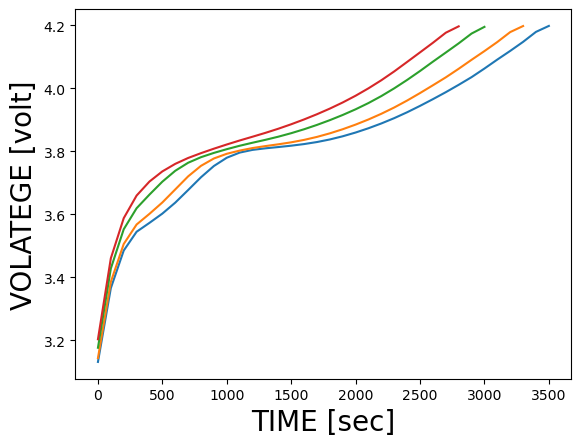

In [25]:
#plot per l'immaginedel workflow

plt.plot(x0000,means0000)
plt.plot(x1000,means1000)
plt.plot(x3000,means3000)
plt.plot(x5000,means5000)
plt.xlabel('TIME [sec]',fontsize=20)
plt.ylabel('VOLATEGE [volt]',fontsize=20)
plt.savefig('plot/Voltage_WORKFLOW.png', dpi=300, bbox_inches="tight")
#plt.grid(True)
plt.show()

In [11]:
# Genera un array di esempio di lunghezza 1000
data0000 = dict_oxford['cyc0000_Cell1']['q']
# Calcola la media e la deviazione standard ogni 50 punti
window_size = 200
means0000 = []
std_devs0000 = []
for i in range(0, len(data0000), window_size):
    window = data0000[i:i + window_size]
    means0000.append(np.mean(window))
    std_devs0000.append(np.std(window))

data1000 = dict_oxford['cyc1000_Cell1']['q']
# Calcola la media e la deviazione standard ogni 50 punti
means1000 = []
std_devs1000 = []
for i in range(0, len(data1000), window_size):
    window = data1000[i:i + window_size]
    means1000.append(np.mean(window))
    std_devs1000.append(np.std(window))

data3000 = dict_oxford['cyc3000_Cell1']['q']
# Calcola la media e la deviazione standard ogni 50 punti
means3000 = []
std_devs3000 = []
for i in range(0, len(data3000), window_size):
    window = data3000[i:i + window_size]
    means3000.append(np.mean(window))
    std_devs3000.append(np.std(window))

data5000 = dict_oxford['cyc5000_Cell1']['q']
# Calcola la media e la deviazione standard ogni 50 punti
means5000 = []
std_devs5000 = []
for i in range(0, len(data5000), window_size):
    window = data5000[i:i + window_size]
    means5000.append(np.mean(window))
    std_devs5000.append(np.std(window))

# Crea gli intervalli per l'asse x
x0000 = np.arange(0, len(data0000), window_size)
x1000 = np.arange(0, len(data1000), window_size)
x3000 = np.arange(0, len(data3000), window_size)
x5000 = np.arange(0, len(data5000), window_size)


# Plot della media e della deviazione standard
plt.figure(figsize=(10, 5))
plt.errorbar(x0000, means0000, std_devs0000, linestyle='None', marker='^', label='0000' )
plt.errorbar(x1000, means1000, std_devs1000, linestyle='None', marker='^', label='1000')
plt.errorbar(x3000, means3000, std_devs3000, linestyle='None', marker='^', label='3000' )
plt.errorbar(x5000, means5000, std_devs5000, linestyle='None', marker='^', label='5000')

plt.title('Media e Deviazione Standard q ogni 100 punti')
plt.xlabel('Time - Charging')
plt.ylabel('Quantity of Energy')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'q'